Looking for cleaned data in: /home/grenadi3/Project-8---Sports-Analysis/data/cleandata

Loading data for seasons: ['21-22', '22-23', '23-24', '24-25'] to create combined_df
  Successfully loaded and added data from: 21-22.csv
  Successfully loaded and added data from: 22-23.csv
  Successfully loaded and added data from: 23-24.csv
  Successfully loaded and added data from: 24-25.csv

Combined data shape: (120, 17)
Performing basic NaN imputation using median...
NaN imputation complete.

==================== Analyzing Target: Wins ====================
  Features used for predicting 'Wins': ['ORTG', 'DRTG', 'TS_Percent', 'TOV_Percent', 'Team_3s_Attempted']
  Data split: Train (90 samples), Test (30 samples)
  Features scaled using StandardScaler.

  --- Linear Regression Model ---
    LR R-squared: 0.905
    LR MAE: 2.591
    LR RMSE: 3.315


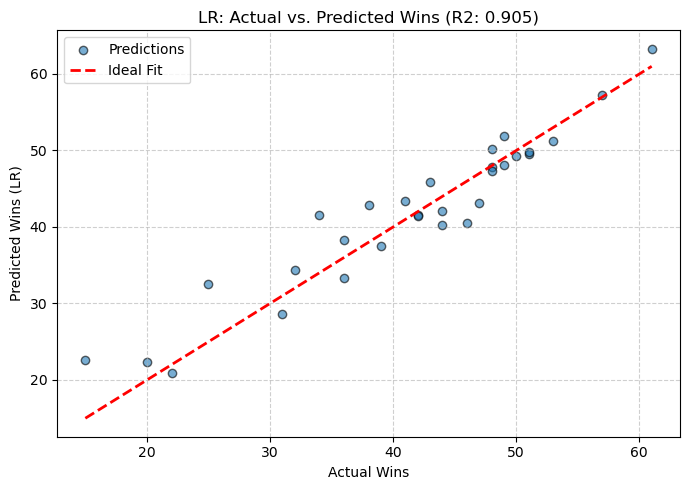

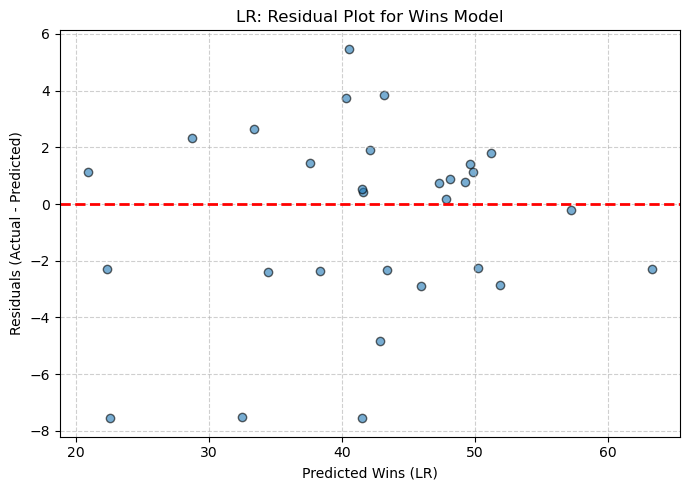


  --- Random Forest Regressor Model ---
    Training Random Forest model...
    Training complete.
    RF R-squared: 0.878
    RF MAE: 3.100
    RF RMSE: 3.756


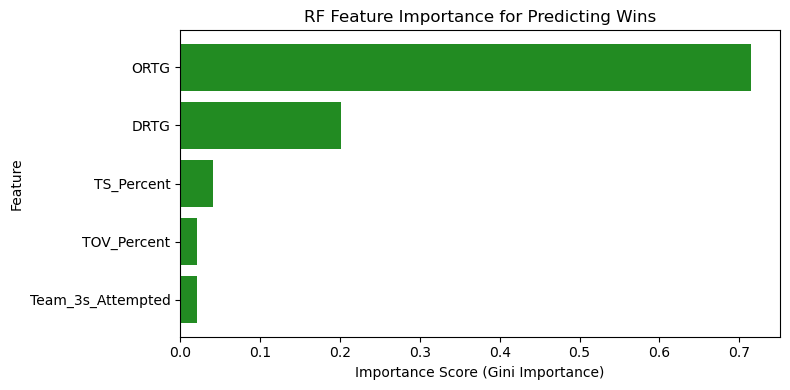


  --- SHAP Analysis (Interpreting Random Forest) ---
    Calculating SHAP values...
    SHAP values calculation complete.


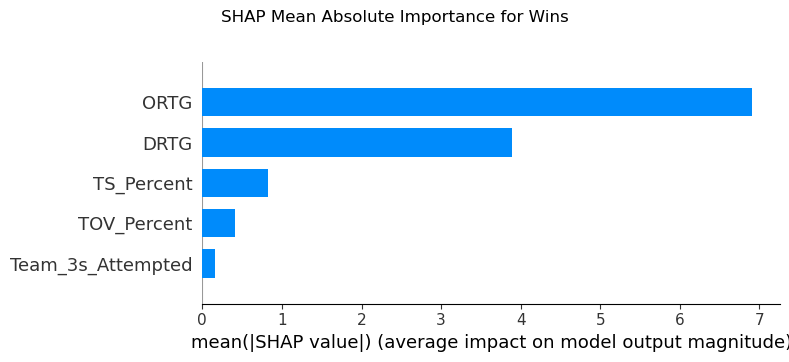

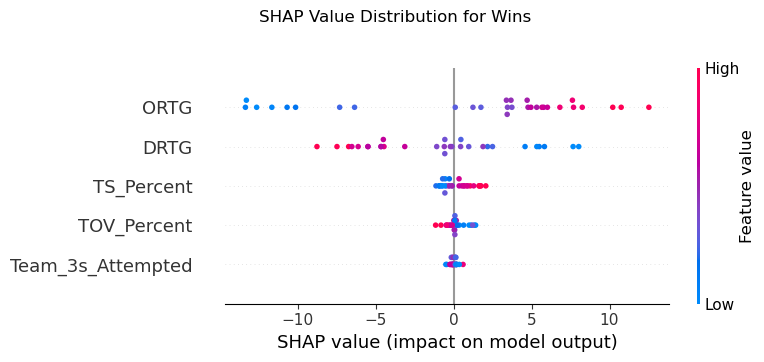


==================== Analyzing Target: ORTG ====================
  Features used for predicting 'ORTG': ['DRTG', 'TS_Percent', 'TOV_Percent', 'Team_3s_Attempted']
  Data split: Train (90 samples), Test (30 samples)
  Features scaled using StandardScaler.

  --- Linear Regression Model ---
    LR R-squared: 0.669
    LR MAE: 1.360
    LR RMSE: 1.654


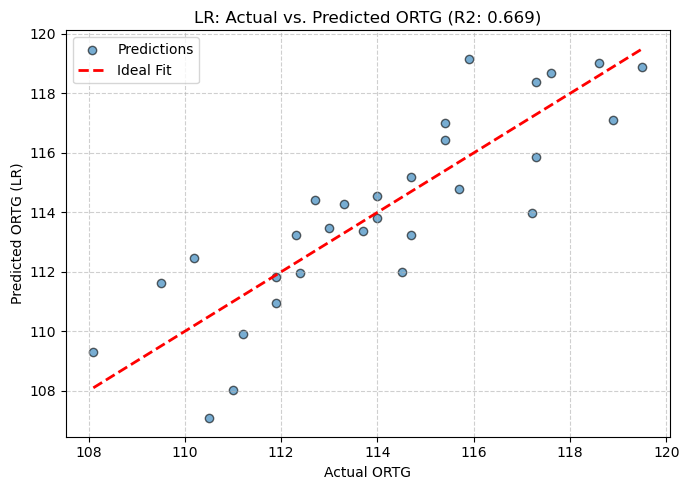

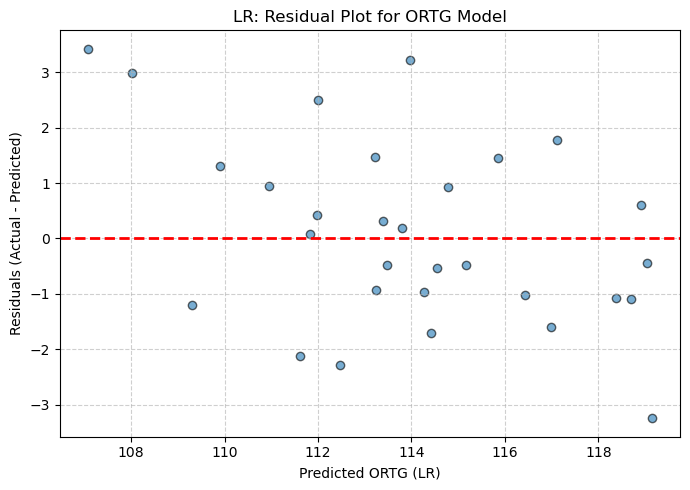


  --- Random Forest Regressor Model ---
    Training Random Forest model...
    Training complete.
    RF R-squared: 0.688
    RF MAE: 1.385
    RF RMSE: 1.607


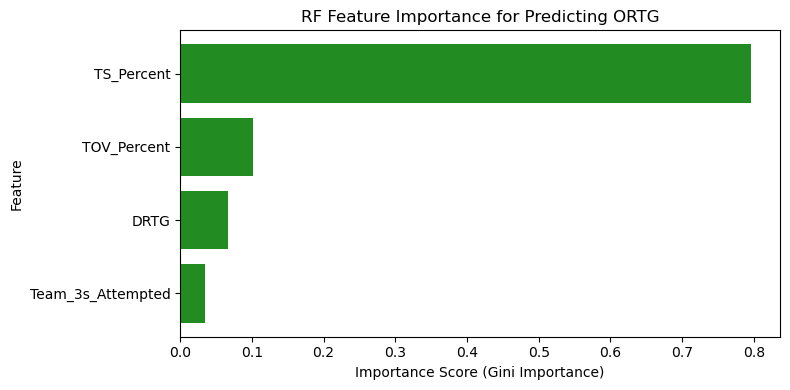


  --- SHAP Analysis (Interpreting Random Forest) ---
    Calculating SHAP values...
    SHAP values calculation complete.


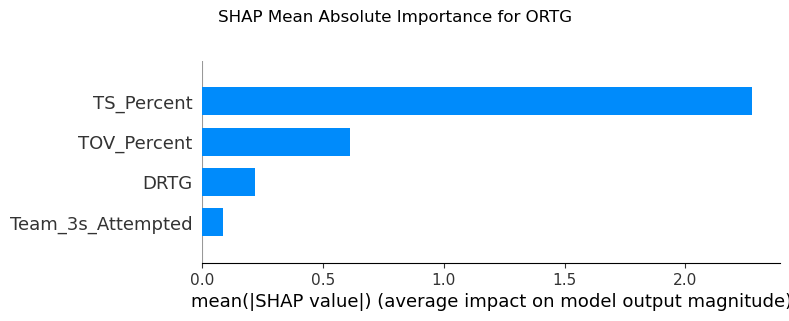

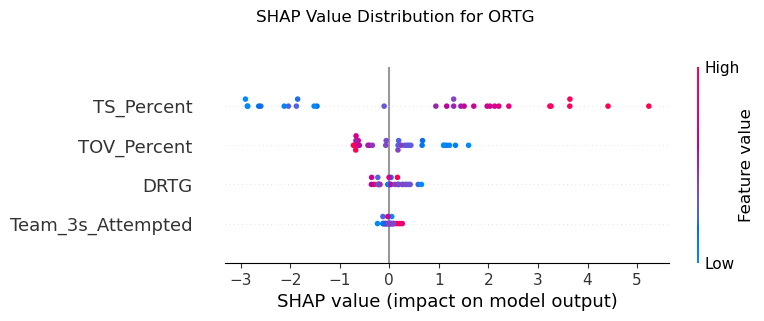


==================== Analysis Loop Complete ====================

--- Model Performance Comparison ---
            R2    MAE   RMSE
Wins_LR  0.905  2.591  3.315
Wins_RF  0.878  3.100  3.756
ORTG_LR  0.669  1.360  1.654
ORTG_RF  0.688  1.385  1.607


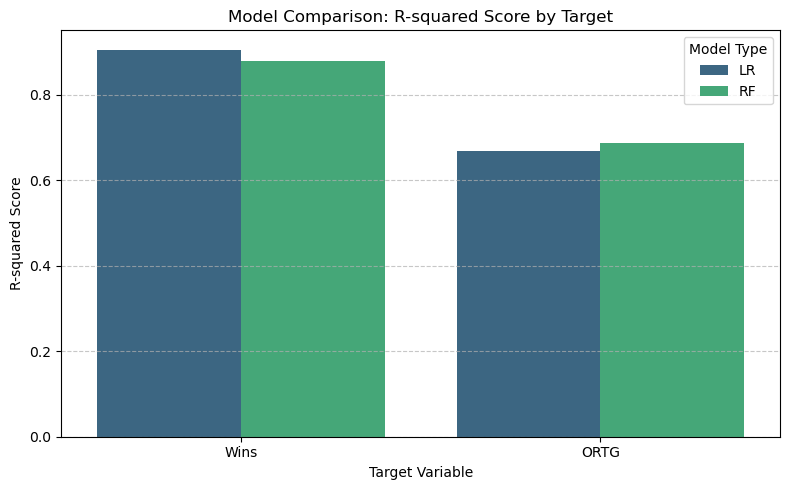


--- Summary Guidance ---
The script has completed the analysis. Review the generated plots and tables above.

Key items for your report/presentation:
1. Model Performance Comparison Table & Plot: Compare R2/MAE/RMSE between Linear Regression (LR) and Random Forest (RF) for predicting 'Wins' and 'ORTG'. Which model performs better for each target?
2. RF Feature Importance Plots: Identify the top-ranked features based on Gini importance for predicting 'Wins' and 'ORTG'.
3. SHAP Plots (Bar & Beeswarm):
   - Bar Plot: Confirm the global importance ranking from SHAP (mean absolute impact).
   - Beeswarm Plot: Explain *how* the most important features impact predictions. Does a higher value of a feature typically increase or decrease the prediction ('Wins' or 'ORTG')? Is the effect consistent?
4. Actual vs. Predicted & Residual Plots (LR): Briefly comment on the goodness-of-fit and identify any patterns in the errors for the simpler linear model (e.g., non-random residuals might indicate no

In [19]:
# -*- coding: utf-8 -*-
"""
NBA Team Performance Prediction and Feature Analysis

This script loads cleaned seasonal NBA team data, preprocesses it,
and then builds and evaluates machine learning models (Linear Regression,
Random Forest) to predict target variables ('Wins', 'ORTG').

It performs the following steps:
1.  Loads and combines cleaned data from multiple seasons.
2.  Performs basic NaN imputation using median values for numeric columns.
3.  Defines feature sets and target variables.
4.  Iterates through each target variable ('Wins', 'ORTG'):
    a. Selects appropriate features.
    b. Splits data into training and testing sets.
    c. Scales features using StandardScaler.
    d. Trains and evaluates a Linear Regression model, generating plots.
    e. Trains and evaluates a Random Forest Regressor model, generating plots.
    f. Performs SHAP analysis on the Random Forest model for interpretability,
       generating global importance (bar) and distribution (beeswarm) plots.
5.  Compares model performance across targets and model types using tables and plots.
6.  Provides summary guidance for interpreting the results.

Inputs:
- Cleaned seasonal CSV files located in '../data/cleandata/' named '{season}.csv'
  (e.g., '21-22.csv'). These files are assumed to contain features like ORTG,
  DRTG, TS_Percent, etc., and the target variables.

Outputs:
- Console output: Prints model performance metrics (R2, MAE, RMSE) and paths.
- Matplotlib plots:
    - Actual vs. Predicted (LR)
    - Residuals (LR)
    - Feature Importance (RF)
    - SHAP Bar Plot (Global Importance)
    - SHAP Beeswarm Plot (Value Distribution)
    - Model Performance Comparison (R-squared Bar Plot)
- A Pandas DataFrame comparing model performance metrics printed to the console.

Dependencies: pandas, numpy, pathlib, matplotlib, seaborn, scikit-learn, shap
"""

import pandas as pd
import numpy as np
# import os # Switched to pathlib
from pathlib import Path # Use pathlib for consistency
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor # Ensemble model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap # Model interpretation library

# --- 1. Load and Prepare Data ---

# Define path to cleaned data directory using pathlib
# Assumes script is run from a location where '../data/' is the correct relative path
load_path = Path('../data/cleandata/')
print(f"Looking for cleaned data in: {load_path.resolve()}") # Show absolute path being used

# Define seasons to load
start_year = 2021
end_year = 2024 # Ensure this covers the seasons with generated weighted averages
seasons = [f"{str(year)[-2:]}-{str(year+1)[-2:]}" for year in range(start_year, end_year + 1)]

all_data = [] # List to hold dataframes from each season
print(f"\nLoading data for seasons: {seasons} to create combined_df")

# Loop through seasons and load corresponding cleaned CSV files
for season in seasons:
    file_path = load_path / f'{season}.csv' # Use pathlib '/' operator for paths
    if file_path.exists():
        try:
            df = pd.read_csv(file_path)
            # Basic check: ensure the file loaded has data
            if not df.empty:
                 all_data.append(df)
                 print(f"  Successfully loaded and added data from: {file_path.name}")
            else:
                 print(f"  Warning: File is empty {file_path.name}")
        except pd.errors.EmptyDataError:
             print(f"  Warning: File is empty {file_path.name}")
        except Exception as e:
            print(f"  Error loading {file_path.name}: {e}")
    else:
        print(f"  Warning: File not found {file_path.name}")

# Check if any data was loaded before proceeding
if not all_data:
    print("\nCRITICAL ERROR: No data loaded. Cannot proceed with analysis. Exiting.")
    exit() # Stop script execution if no data is available
else:
    # Concatenate all loaded seasonal dataframes into one
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\nCombined data shape: {combined_df.shape}")

    # --- Basic Data Cleaning: Handle Missing Values ---
    print("Performing basic NaN imputation using median...")
    # Select only numeric columns for imputation check
    numeric_cols_to_check = combined_df.select_dtypes(include=np.number).columns
    for col in numeric_cols_to_check:
        if combined_df[col].isnull().any():
            # Impute with median: generally more robust to outliers than mean
            # Note: This is a basic strategy. More advanced imputation might be needed
            # depending on the extent and nature of missing data.
            median_val = combined_df[col].median()
            combined_df[col].fillna(median_val, inplace=True)
            print(f"  Filled NaNs in '{col}' with median value ({median_val:.3f})")
    print("NaN imputation complete.")
    # print(combined_df.info()) # Optional: Check dtypes and non-null counts

# --- 2. Define Feature Sets and Target Variables ---
# List of potential features to be used in the models
base_features = [
    'ORTG', # Offensive Rating
    'DRTG', # Defensive Rating
    'TS_Percent', # True Shooting Percentage
    'TOV_Percent', # Turnover Percentage
    'Team_3s_Attempted', # Team 3-pointers Attempted
    'Weighted_Avg_Height', # Custom calculated feature
    'Weighted_Avg_Wingspan' # Custom calculated feature
]
# List of target variables we want to predict
targets = ['Wins', 'ORTG'] # Predict Wins and Offensive Rating

# --- 3. Initialize Results Storage ---
# Dictionary to store performance metrics (R2, MAE, RMSE) for each model and target
model_results = {}

# --- 4. Loop Through Targets for Modeling and Analysis ---
for target in targets:
    print(f"\n{'='*20} Analyzing Target: {target} {'='*20}")

    # --- Feature Selection based on Target ---
    # Dynamically select features, ensuring the target variable itself is not used as a feature
    if target == 'Wins':
        # Use all base features available in the dataframe
        current_features = [f for f in base_features if f in combined_df.columns]
    elif target == 'ORTG':
        # Use all base features except ORTG itself
        current_features = [f for f in base_features if f != 'ORTG' and f in combined_df.columns]
    else:
        # Configuration for other targets would be needed here
        print(f"Target '{target}' analysis is not configured. Skipping.")
        continue # Move to the next target

    # Verify that features were found and data exists
    if not current_features:
        print(f"  No valid features found in the dataframe for target '{target}'. Skipping.")
        continue

    # Define Feature matrix (X) and Target vector (y)
    X = combined_df[current_features]
    y = combined_df[target]

    # Check for empty dataframes before proceeding
    if X.empty or y.empty:
        print(f"  Feature set (X) or target vector (y) is empty for '{target}'. Skipping.")
        continue
    print(f"  Features used for predicting '{target}': {current_features}")

    # --- Data Splitting ---
    # Split data into training (75%) and testing (25%) sets
    # random_state=42 ensures reproducibility of the split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    print(f"  Data split: Train ({X_train.shape[0]} samples), Test ({X_test.shape[0]} samples)")

    # --- Feature Scaling ---
    # Scale features using StandardScaler (mean=0, variance=1)
    # Fit scaler ONLY on training data to prevent data leakage from test set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) # Apply the same transformation to test data
    print("  Features scaled using StandardScaler.")

    # --- 5. Linear Regression ---
    print("\n  --- Linear Regression Model ---")
    # Initialize and train the model on scaled training data
    model_lr = LinearRegression()
    model_lr.fit(X_train_scaled, y_train)

    # Predict on the scaled test data
    y_pred_lr = model_lr.predict(X_test_scaled)

    # Evaluate the model
    r2_lr = r2_score(y_test, y_pred_lr)
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr)) # Calculate RMSE from MSE
    print(f"    LR R-squared: {r2_lr:.3f}")
    print(f"    LR MAE: {mae_lr:.3f}")
    print(f"    LR RMSE: {rmse_lr:.3f}")

    # Store results
    model_results[f'{target}_LR'] = {'R2': r2_lr, 'MAE': mae_lr, 'RMSE': rmse_lr}

    # --- Linear Regression Plots ---
    # Actual vs. Predicted Plot
    plt.figure(figsize=(7, 5))
    # Scatter plot: actual (y_test) vs predicted (y_pred_lr)
    plt.scatter(y_test, y_pred_lr, alpha=0.6, edgecolors='k', label='Predictions')
    # Line y=x (perfect prediction line)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Ideal Fit')
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target} (LR)")
    plt.title(f"LR: Actual vs. Predicted {target} (R2: {r2_lr:.3f})")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Residual Plot
    residuals_lr = y_test - y_pred_lr # Calculate residuals
    plt.figure(figsize=(7, 5))
    # Scatter plot: predicted values vs residuals
    plt.scatter(y_pred_lr, residuals_lr, alpha=0.6, edgecolors='k')
    # Horizontal line at zero (ideal residual mean)
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.xlabel(f"Predicted {target} (LR)")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"LR: Residual Plot for {target} Model")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- 6. Random Forest Regression ---
    print("\n  --- Random Forest Regressor Model ---")
    # Initialize the model
    # n_estimators=100: Number of trees in the forest (common default)
    # random_state=42: Ensures reproducibility
    # n_jobs=-1: Use all available CPU cores for training
    model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    # Train the model using the scaled training data (RF can handle unscaled too, but using scaled for consistency here)
    print("    Training Random Forest model...")
    model_rf.fit(X_train_scaled, y_train)
    print("    Training complete.")

    # Predict on the scaled test data
    y_pred_rf = model_rf.predict(X_test_scaled)

    # Evaluate the model
    r2_rf = r2_score(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf)) # Calculate RMSE
    print(f"    RF R-squared: {r2_rf:.3f}")
    print(f"    RF MAE: {mae_rf:.3f}")
    print(f"    RF RMSE: {rmse_rf:.3f}")

    # Store results
    model_results[f'{target}_RF'] = {'R2': r2_rf, 'MAE': mae_rf, 'RMSE': rmse_rf}

    # --- Random Forest Feature Importance Plot ---
    # Extract feature importances from the trained model
    importances_rf = model_rf.feature_importances_
    # Create a DataFrame for easier sorting and plotting
    feature_importance_df = pd.DataFrame({'Feature': current_features, 'Importance': importances_rf})
    # Sort features by importance (descending)
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(8, max(4, len(current_features) * 0.4))) # Adjust height based on number of features
    # Create horizontal bar plot
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='forestgreen')
    plt.xlabel("Importance Score (Gini Importance)")
    plt.ylabel("Feature")
    plt.title(f"RF Feature Importance for Predicting {target}")
    plt.gca().invert_yaxis() # Display the most important feature at the top
    plt.tight_layout()
    plt.show()

    # --- 7. SHAP Analysis (using Random Forest model) ---
    # SHAP provides more detailed insights into feature contributions than standard importance
    print("\n  --- SHAP Analysis (Interpreting Random Forest) ---")

    # Use TreeExplainer for tree-based models like Random Forest
    explainer = shap.TreeExplainer(model_rf)

    # Calculate SHAP values for the test set.
    # It's recommended to calculate on the scaled data the model was trained on.
    print("    Calculating SHAP values...")
    shap_values = explainer.shap_values(X_test_scaled)
    print("    SHAP values calculation complete.")

    # For plotting, use a DataFrame with original feature names for labels,
    # but the SHAP values correspond to the scaled data.
    X_test_df_for_shap = pd.DataFrame(X_test_scaled, columns=current_features)

    # SHAP Bar Plot (Shows mean absolute SHAP value per feature - Global Importance)
    plt.figure()
    shap.summary_plot(shap_values, X_test_df_for_shap, plot_type="bar", show=False)
    # Add title manually as SHAP can sometimes interfere with plt.title
    fig_bar = plt.gcf()
    fig_bar.suptitle(f"SHAP Mean Absolute Importance for {target}", y=1.02) # Adjust y for spacing if needed
    plt.tight_layout()
    plt.show()

    # SHAP Beeswarm Plot (Shows distribution of SHAP values for each feature)
    # Reveals not just importance but also direction of impact and variation
    plt.figure()
    shap.summary_plot(shap_values, X_test_df_for_shap, plot_type="dot", show=False) # 'dot' is beeswarm
    fig_beeswarm = plt.gcf()
    fig_beeswarm.suptitle(f"SHAP Value Distribution for {target}", y=1.02) # Adjust y for spacing
    plt.tight_layout()
    plt.show()

print(f"\n{'='*20} Analysis Loop Complete {'='*20}")

# --- 8. Post-Loop Summaries & Comparisons ---

# Create Performance Comparison Table
# Convert the results dictionary to a DataFrame for easy viewing
# Transpose (.T) so models/targets are rows and metrics are columns
try:
    results_df = pd.DataFrame(model_results).T
    print("\n--- Model Performance Comparison ---")
    # Optional: Format the numbers for better readability
    print(results_df.round(3))
except Exception as e:
    print(f"\nError creating results DataFrame: {e}")
    results_df = None # Ensure variable exists even if creation fails


# Create Performance Comparison Plot (R-squared)
if results_df is not None and not results_df.empty:
    # Prepare data for plotting R-squared comparison
    # Assumes index is like 'Wins_LR', 'Wins_RF', 'ORTG_LR', 'ORTG_RF'
    r2_data_dict = {'Target': [], 'Model': [], 'R2': []}
    for idx, row in results_df.iterrows():
        try:
            target_name, model_name = idx.split('_', 1) # Split only on the first underscore
            r2_data_dict['Target'].append(target_name)
            r2_data_dict['Model'].append(model_name)
            r2_data_dict['R2'].append(row['R2'])
        except ValueError:
             print(f"Warning: Could not parse index '{idx}' for plotting. Skipping this entry.")
             continue # Skip rows with unexpected index format

    if r2_data_dict['Target']: # Check if any data was successfully parsed
        r2_data_plot = pd.DataFrame(r2_data_dict)

        plt.figure(figsize=(8, 5))
        # Use seaborn barplot for grouped comparison
        sns.barplot(data=r2_data_plot, x='Target', y='R2', hue='Model', palette='viridis')
        plt.title('Model Comparison: R-squared Score by Target')
        plt.ylabel('R-squared Score')
        plt.xlabel('Target Variable')
        # Adjust y-axis to start slightly below the minimum R2 or 0
        min_r2 = r2_data_plot['R2'].min()
        plt.ylim(bottom=min(0, min_r2 - 0.05))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(title='Model Type')
        plt.tight_layout()
        plt.show()
    else:
        print("\nCould not generate R-squared comparison plot due to issues parsing results index.")
else:
    print("\nResults DataFrame is empty or failed to create. Skipping comparison plot.")


# --- 9. Summary Guidance (Text Output) ---
# Provide textual summary and next steps based on the analysis performed
print("\n--- Summary Guidance ---")
print("The script has completed the analysis. Review the generated plots and tables above.")
print("\nKey items for your report/presentation:")
print("1. Model Performance Comparison Table & Plot: Compare R2/MAE/RMSE between Linear Regression (LR) and Random Forest (RF) for predicting 'Wins' and 'ORTG'. Which model performs better for each target?")
print("2. RF Feature Importance Plots: Identify the top-ranked features based on Gini importance for predicting 'Wins' and 'ORTG'.")
print("3. SHAP Plots (Bar & Beeswarm):")
print("   - Bar Plot: Confirm the global importance ranking from SHAP (mean absolute impact).")
print("   - Beeswarm Plot: Explain *how* the most important features impact predictions. Does a higher value of a feature typically increase or decrease the prediction ('Wins' or 'ORTG')? Is the effect consistent?")
print("4. Actual vs. Predicted & Residual Plots (LR): Briefly comment on the goodness-of-fit and identify any patterns in the errors for the simpler linear model (e.g., non-random residuals might indicate non-linearities not captured).")

print("\nNext Steps:")
print("- Synthesize Findings: Clearly list the most influential factors driving team Wins and Offensive Rating based on the combined evidence from RF importance and SHAP analysis.")
print("- Consider Model Limitations: Acknowledge the basic imputation method used, the specific features included/excluded, and the potential for more complex models or feature engineering.")
print("- (Optional) Statistical Significance: Refer back to separate analysis using libraries like 'statsmodels' if p-values and confidence intervals for linear relationships are needed for the report.")
print("- Report & Presentation: Incorporate the key visuals (plots, tables) and your interpretations into your final report and presentation slides. Ensure clear headings, labels, and explanations for all figures.")